In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from admm import run_admm
%load_ext pyinstrument

# autoreload for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# generate a gaussian mixture model with 2 components, one with weight .8 and
# the other with weight .2. The mean of the first should be .2, and the mean of 
# the second should be -.2. There should be d dimensions, and the covariance is
# the identity in the first, and sigma * identity in the second.
def generate_gmm(m, d, sigma):
    X = np.random.randn(m, d)
    y = np.random.binomial(1, .8, m)
    X[y == 1] += .2
    X[y == 0] -= .2
    X[y == 0] *= sigma

    # compute the empirical covariance matrix
    P = np.cov(X.T)
    # compute the mean of the data
    q = np.mean(X, axis=0)
    
    return -X, P, -q

In [33]:
np.random.seed(0)
m = 100_000
d = 1000
A, P, q = generate_gmm(m, d, 2)

beta = .1
kappa = .2

k = int(beta * m)
alpha = kappa * k

gamma = .05

A_box = np.eye(d)
A_total = np.ones((1, d))

def box_prox(z):
    return np.clip(z, 0, lim)

def total_prox(z):
    return np.clip(z, 0, 1)

proj_As = [A_box, A_total]
proj_fns = [box_prox, total_prox]

lim = 1
def gen_constraints(x):
    return [
        0 <= cp.sum(x), cp.sum(x) <= 1,
        0 <= x, x <= lim,
    ]

def gen_objective(x):
    return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)

In [34]:
q.max(), q.min(), kappa, A.max(), A.min()

(-0.06746340212706711,
 -0.09354192348533061,
 0.2,
 10.919361215062876,
 -10.490861349815166)

In [35]:
# solve the problem with cvxpy for reference
x_cvxpy = cp.Variable(d)
objective = gen_objective(x_cvxpy)
constraints = gen_constraints(x_cvxpy)
constraints += [
    cp.sum_largest(A@x_cvxpy, k) <= alpha ,
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print(prob.value)
# print the sum of the largest k elements of A @ x_cvxpy.value
print(np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Apr 26 05:49:55 PM: Your problem has 1000 variables, 5 constraints, and 0 parameters.
(CVXPY) Apr 26 05:49:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 05:49:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 26 05:49:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 26 05:49:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 26 05:49:55 PM: Compiling problem (target solver=MOSEK).
(

In [36]:
# warm start with fewer scenarios
m_ = 1_000
A_ = A[:m_]
k_ = int(beta * m_)
alpha_ = kappa * k_
x_cvxpy_ = cp.Variable(d)

objective_ = gen_objective(x_cvxpy_)
constraints_ = gen_constraints(x_cvxpy_)
constraints_ += [
    cp.sum_largest(A_@x_cvxpy_, k_) <= alpha_ , 
]
prob_ = cp.Problem(objective_, constraints_)
prob_.solve(solver=cp.MOSEK)
print(prob_.value)
print(np.sort(A_ @ x_cvxpy_.value)[::-1][:k].sum() / m_, kappa)

-0.07990124198170397
-0.12849146982378923 0.2


In [43]:
%%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, 
     max_iter=1000, 
     alpha_over=1.7, rho=1, 
     warm=x_cvxpy_.value, 
     # constraint_func=gen_constraints
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

iter: 0, objval: -0.00555052845534173, r_norm: 0.181541010144479, s_norm: 16.27287251499979, u_norm: 0.0, time: 3.929211139678955
iter: 100, objval: -0.005625092182750407, r_norm: 0.0008819192141142952, s_norm: 0.05247064885610258, u_norm: 0.0, time: 66.46492576599121
iter: 200, objval: -0.005678623966722992, r_norm: 0.0007758442562392545, s_norm: 0.10463348308862908, u_norm: 0.0, time: 131.32810401916504
iter: 300, objval: -0.005742304495102707, r_norm: 0.0015766340178943023, s_norm: 0.043385401196437585, u_norm: 0.0, time: 196.24932074546814
iter: 400, objval: -0.0058167006514699224, r_norm: 0.00096831479498323, s_norm: 0.017467238447503954, u_norm: 0.0, time: 260.7734398841858
iter: 500, objval: -0.005897292549732019, r_norm: 0.00324637096263698, s_norm: 0.038543702649463614, u_norm: 0.0, time: 325.80111718177795
iter: 600, objval: -0.005968108072478269, r_norm: 0.0024929695514509815, s_norm: 0.07066514872175336, u_norm: 0.00018974770316049216, time: 389.36868596076965
iter: 700, ob

_     ._   __/__   _ _  _  _ _/_   Recorded: 21:52:36  Samples:  33952
 /_//_/// /_\ / //_// / //_'/ //     Duration: 647.293   CPU time: 4295.435
/   _/                      v4.6.2

Program: /Users/ericluxenberg/Desk/Boyd/cvar-opt-code/venv/lib/python3.9/site-packages/ipykernel_launcher.py --f=/Users/ericluxenberg/Library/Jupyter/runtime/kernel-v2-5328koot17pYPYZy.json

647.315 <module>  ../../../../../var/folders/ky/wgcl3ykn47bfh92cdqzv8mq00000gn/T/ipykernel_5724/2163568567.py:2
`- 647.280 run_admm  admm.py:82
   |- 602.064 x_update_cvxpy  admm.py:243
   |  |- 564.059 solver  admm.py:23
   |  |  `- 563.900 Problem.solve  cvxpy/problems/problem.py:419
   |  |        [24 frames hidden]  cvxpy, mosek, <built-in>, scipy
   |  |           285.788 Task.optimizetrm__1  <built-in>
   |  |           133.603 coo_matrix._sum_duplicates  scipy/sparse/_coo.py:541
   |  `- 38.005 [self]  admm.py
   |- 12.213 proj_sum_largest_cpp  cvar_proj.py:149
   |  `- 11.368 _sort_z  cvar_proj.py:17
   |     `- 11.149 argsort  numpy/core/fromnumeric.py:1025
   |           [3 frames hidden]  numpy, <built-in>
   |- 11.641 over_relax_z_hat  admm.py:157
   `- 10.710 construct_cvxpy_prob  admm.py:8
      `- 10.627 Problem.solve  cvxpy/problems/problem.py:419
            [3 frames hidden]  cvxpy

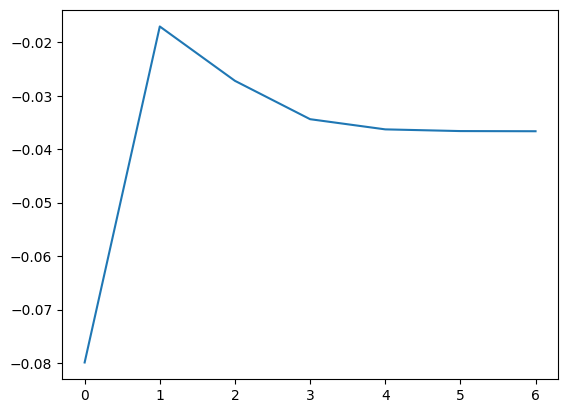

In [38]:
plt.plot(history["objval"])

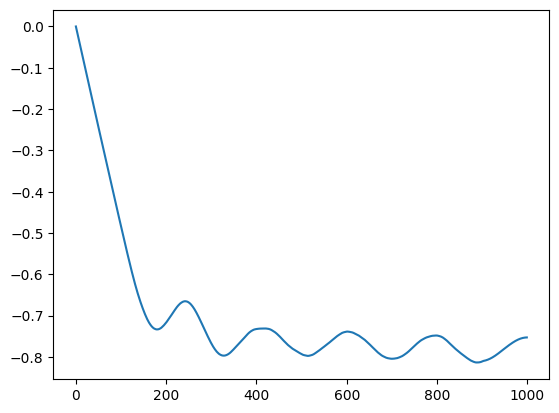

In [98]:
# plt.plot(history["objval"]) # 100k .7 rho

In [121]:
x.min(), x.max(), x.sum(), x_cvxpy.value.min(), x_cvxpy.value.max(), x_cvxpy.value.sum()

(-9.239992264822045e-06,
 0.017336139567720708,
 0.30837140521800793,
 3.911073296449167e-09,
 0.017803137069810192,
 0.30719016637160734)

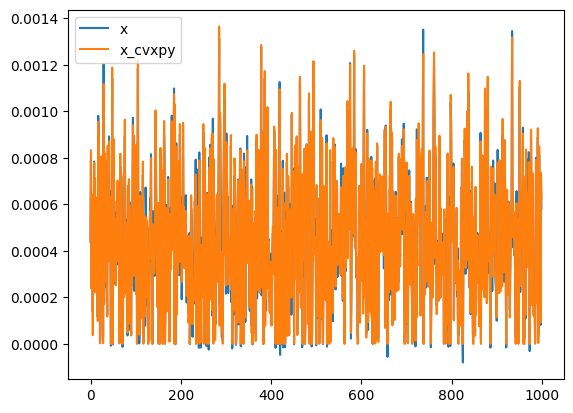

In [151]:
plt.plot(x, label="x")
plt.plot(x_cvxpy.value, label="x_cvxpy")
plt.legend()